# Species-tree & species-delimitation using *bpp* (BP&P)
The program *bpp* by Rannala & Yang (2010; 2015) is a powerful tool for inferring species tree parameters and testing species delimitation hypotheses. It is *relatively* easy to use, and best of all, it's *quite fast*, although not highly parallelizable. This notebook describes a streamlined approach to easily setup input files for testing different hypthotheses in *bpp*, and to do so in a clear programmatic way that makes it easy to perform many tests over many different parameter settings. We also show how to distribute many separate jobs to run in parallel on a cluster. 

## Notebook setup
This is a Jupyter notebook, a reproducible and executable document. The code in this notebook is Python (2.7), and should be executed in a jupyter-notebook like this one. Execute each cell in order to reproduce our entire analysis. The example data set used in this analysis is from the [empirical example ipyrad tutorial](http://ipyrad.readthedocs.io/pedicularis_.html).

### Install required software
All software required for this notebook can be installed using conda. 

In [1]:
## conda install -c ipyrad ipyrad
## conda install -c ipyrad bpp
## conda install -c eaton-lab toytree

In [2]:
import ipyrad.analysis as ipa         ## ipyrad analysis tools
import ipyparallel as ipp             ## parallelization
import pandas as pd                   ## DataFrames
import numpy as np                    ## data generation
import toytree                        ## tree plotting
import toyplot                        ## data plotting

### Connect to an ipyparallel cluster
We will use the `ipyparallel` library to submit jobs to run in parallel on a cluster. You will need to have an `ipcluster` instance running in a separate terminal on your machine (or ideally, it is running on your HPC cluster). The code below simply connects to that cluster and prints how many CPUs are available for use. 

In [3]:
## Connect to a running ipcluster instance
ipyclient = ipp.Client()

## print information about our cluster
print "Connected to {} cores".format(len(ipyclient))

Connected to 4 cores


## Analysis setup

You must define a tree with the "species" names in your analysis which will act either as a fixed-tree or as a guide-tree for your analysis. You must  also define an `IMAP` dictionary which maps sample names to "species" names. And you can optionally also define a `MINMAP` dictionary which is used to filter RAD loci to include only loci that have at least N samples with data from each species in a locus.  

In [4]:
## set the location of our input .loci file
locifile = "./analysis-ipyrad/pedic-full_outfiles/pedic-full.alleles.loci"

## a tree hypothesis (guidetree) (here based on tetrad results)
newick = "((((((rex, lip),rck),tha),cup),(cys,(cya, sup))),prz);"

## a dictionary mapping sample names to 'species' names
imap = {
    "prz": ["32082_przewalskii", "33588_przewalskii"],
    "cys": ["41478_cyathophylloides", "41954_cyathophylloides"],
    "cya": ["30686_cyathophylla"],
    "sup": ["29154_superba"],
    "cup": ["33413_thamno"],
    "tha": ["30556_thamno"],
    "rck": ["35236_rex"],
    "rex": ["35855_rex", "40578_rex"],
    "lip": ["39618_rex", "38362_rex"],  
    }

## optional: loci will be filtered if they do not have data for at
## least N samples/individuals in each species.
minmap = {
    "prz": 2,
    "cys": 2,
    "cya": 1,
    "sup": 1,
    "cup": 1,
    "tha": 1, 
    "rck": 1,
    "rex": 2,
    "lip": 2,
    }

In [5]:
## check your (starting) tree hypothesis
toytree.tree(newick).draw(width=250);


prz cys cya sup cup tha rck rex lip

## The *bpp* Class object

To simplify the creation of input files for *bpp* analyses we've created a bpp job generator object that can be accessed from `ipa.bpp()`. Running *bpp* requires three input files (.ctl, .imap, and .seq) of which the .ctl file is the most important since it contains the parameters for a run and points to the location of the other two files. The `ipa.bpp()` object can be used to easily modify parameter settings for a run, to generate the input files, and if desired, to submit the bpp jobs to run on a cluster (your ipyclient cluster). 

In [6]:
## create a bpp object to run algorithm 00
b = ipa.bpp(
    name="test",
    data=locifile,
    guidetree=newick, 
    imap=imap,
    minmap=minmap,   
    )

In [7]:
## set some optional params, leaving others at their defaults
b.params.burnin = 2000
b.params.nsample = 10000
b.params.sampfreq = 2
b.params.seed = 98765

## print params
b.params

burnin          2000                
cleandata       0                   
delimit_alg     (0, 5)              
finetune        (0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01)
infer_delimit   0                   
infer_sptree    0                   
nsample         10000               
sampfreq        2                   
seed            98765               
tauprior        (2, 2000, 1)        
thetaprior      (2, 2000)           
usedata         1                   

In [8]:
## set some optional filters leaving others at their defaults
b.filters.maxloci=100
b.filters.minsnps=0

## print filters
b.filters

maxloci   100                 
minmap    {'cys': 4, 'rex': 4, 'cup': 2, 'rck': 2, 'cya': 2, 'lip': 4, 'sup': 2, 'tha': 2, 'prz': 4}
minsnps   0                   

### Generating files &/or submitting jobs
When you create a *bpp* object you save it with a variable name (in this example named `test`) which is simply the name you will use to reference the object. You must also provide a *name* (prefix for output files) that will be used by either of the two main functions of the bpp object: **write_bpp_files()** or **run()**. Both functions make it easy to sample different distributions of loci to include in different replicate bpp analyses. Each replicate will start from a different random seed after the initial `seed`. If you used a `maxloci` argument to limit the number of loci that will used in the analysis then you can also use the `randomize_order` argument to select a different random number of N loci in each rep, otherwise just the first N loci that pass filtering will be sampled. 

#### `write_bpp_files()`
This writes the .ctl, .seq, and .imap files for the specified run. 

In [9]:
## write files (filtered based on test.filters and test.params)
b.write_bpp_files()

input files created for job test (100 loci)


#### `run()`
This writes the files for each job and submits the bpp jobs to run on the cluster designated by the *ipyclient* object. You can efficiently submit many replicate jobs in this way. 

In [11]:
## or, write files and submit job to run on ipyclient 
b.run(
    nreps=4, 
    ipyclient=ipyclient, 
    randomize_order=True,
    )

submitted 4 bpp jobs [test_r3] (100 loci)


#### Accessing job results
When you submit jobs the results files will be stored in the bpp objects `.files` attribute. In addition, the asychronous result objects (a representation of the running job) from each submitted job will be accessible from the `.asyncs` attribute of the bpp object. You can view these objects to see if your job has finished or use them to trace errors if an error arises, as we do below. 

In [13]:
## files associated with the bpp object (includes replicates)
b.files

data        ./analysis-ipyrad/pedic-full_outfiles/pedic-full.alleles.loci
mcmcfiles   ['~/Documents/ipyrad/tests/analysis-bpp/test.mcmc.txt', '~/Documents/ipyrad/tests/analysis-bpp/test_r0.mcmc.txt', '~/Documents/ipyrad/tests/analysis-bpp/test_r1.mcmc.txt', '~/Documents/ipyrad/tests/analysis-bpp/test_r2.mcmc.txt', '~/Documents/ipyrad/tests/analysis-bpp/test_r3.mcmc.txt']
outfiles    ['~/Documents/ipyrad/tests/analysis-bpp/test.out.txt', '~/Documents/ipyrad/tests/analysis-bpp/test_r0.out.txt', '~/Documents/ipyrad/tests/analysis-bpp/test_r1.out.txt', '~/Documents/ipyrad/tests/analysis-bpp/test_r2.out.txt', '~/Documents/ipyrad/tests/analysis-bpp/test_r3.out.txt']

In [14]:
## check async objects from the bpp object
for job in b.asyncs:
    if job.ready():
        print 'job finished'
    else:
        print 'job running'

job running
job running
job running
job running


In [15]:
## uncomment and run this to block until all running jobs are finished
#ipyclient.wait()

--------------
## Examples 
--------------

## Algorithm 00 - fixed tree parameter inference

The 00 algorithm means `'infer_sptree=0'` and `'infer_delimit=0'`, thus the tree that you enter will be treated as the fixed species tree and the analysis will infer parameters for the tree under the multispecies coalescent model. This will yield values of $\Theta$ for each branch of the tree, and divergence times ($\tau$) for each split in the tree. 

In [16]:
## create two new copies of the bpp object above, but with new names
A00 = b.copy(name="A00")
A00n = b.copy(name="A00-nodata")

## set params on the 'nodata' object to not use seq data
A00n.params.usedata = 0

In [17]:
## submit a few replicate jobs from different random seeds 
A00.run(nreps=3, randomize_order=True, ipyclient=ipyclient)
A00n.run(nreps=1, randomize_order=True, ipyclient=ipyclient)

submitted 3 bpp jobs [A00_r2] (100 loci)
submitted 1 bpp jobs [A00-nodata_r0] (100 loci)


In [16]:
## wait for jobs to finish
ipyclient.wait()

#### Summarize results tables for algorithm 00
Different bpp algorithms produce different types of results files. For algorithm 00 the mcmc results file is simply a table of $\Theta$ and $\tau$ values so we can just parse it as a CSV file to summarize results. The same results will be available in the `.out.txt` file, but I find that parsing the results this way is a bit easier to view. 

#### The 'no-data' results
We expect that when we use no data the priors will be returned. In this case we see no significant differences in theta values among samples, which is good. The tau values will be distributed according to the prior on the root divergence, with the other nodes distributed according to a dirichlet process. It will be of interest to compare these divergence time estimates to the ones produced by the analysis *with sequence data*, to assess whether the sequence data causing the divergence times estimates to diverge significantly from their priors. 

In [18]:
## set options to print prettier tables
## (this suppresses scientific notation)
pd.set_option('display.float_format', lambda x: '%.4f' % x)

In [23]:
## parse the mcmc table
table1 = pd.read_csv(A00n.files.mcmcfiles[0], sep="\t", index_col=0)
table1.describe().T

count   mean    std    min    25%  \
theta_1cup                          10000.0000 0.0012 0.0007 0.0002 0.0007   
theta_2cya                          10000.0000 0.0009 0.0007 0.0000 0.0005   
theta_3cys                          10000.0000 0.0009 0.0008 0.0000 0.0004   
theta_4lip                          10000.0000 0.0012 0.0007 0.0001 0.0006   
theta_5prz                          10000.0000 0.0010 0.0006 0.0001 0.0005   
theta_6rck                          10000.0000 0.0009 0.0007 0.0000 0.0004   
theta_7rex                          10000.0000 0.0011 0.0007 0.0001 0.0005   
theta_8sup                          10000.0000 0.0010 0.0007 0.0001 0.0005   
theta_9tha                          10000.0000 0.0011 0.0007 0.0001 0.0006   
theta_10rexliprckthacupcyscyasupprz 10000.0000 0.0008 0.0006 0.0001 0.0004   
theta_11rexliprckthacupcyscyasup    10000.0000 0.0011 0.0007 0.0001 0.0006   
theta_12rexliprckthacup             10000.0000 0.0006 0.0007 0.0000 0.0001   
theta_13rexliprcktha                10000.0000 0.0011 0.0007 0.0001 0.0006   
theta_14rexliprck                   10000.0000 0.0011 0.0008 0.0001 0.0006   
theta_15rexlip                      10000.0000 0.0011 0.0007 0.0001 0.0006   
theta_16cyscyasup                   10000.0000 0.0010 0.0007 0.0001 0.0005   
theta_17cyasup                      10000.0000 0.0009 0.0007 0.0001 0.0004   
tau_10rexliprckthacupcyscyasupprz   10000.0000 0.0011 0.0006 0.0002 0.0006   
tau_11rexliprckthacupcyscyasup      10000.0000 0.0010 0.0006 0.0001 0.0005   
tau_12rexliprckthacup               10000.0000 0.0008 0.0005 0.0001 0.0005   
tau_13rexliprcktha                  10000.0000 0.0007 0.0004 0.0001 0.0004   
tau_14rexliprck                     10000.0000 0.0004 0.0003 0.0000 0.0002   
tau_15rexlip                        10000.0000 0.0002 0.0002 0.0000 0.0001   
tau_16cyscyasup                     10000.0000 0.0007 0.0005 0.0001 0.0004   
tau_17cyasup                        10000.0000 0.0005 0.0005 0.0000 0.0001   

                                       50%    75%    max  
theta_1cup                          0.0010 0.0015 0.0071  
theta_2cya                          0.0008 0.0013 0.0063  
theta_3cys                          0.0007 0.0012 0.0055  
theta_4lip                          0.0010 0.0016 0.0052  
theta_5prz                          0.0008 0.0013 0.0049  
theta_6rck                          0.0008 0.0013 0.0055  
theta_7rex                          0.0009 0.0014 0.0066  
theta_8sup                          0.0009 0.0014 0.0057  
theta_9tha                          0.0009 0.0014 0.0053  
theta_10rexliprckthacupcyscyasupprz 0.0006 0.0010 0.0040  
theta_11rexliprckthacupcyscyasup    0.0010 0.0014 0.0048  
theta_12rexliprckthacup             0.0003 0.0009 0.0049  
theta_13rexliprcktha                0.0009 0.0014 0.0056  
theta_14rexliprck                   0.0010 0.0015 0.0055  
theta_15rexlip                      0.0009 0.0014 0.0059  
theta_16cyscyasup                   0.0008 0.0013 0.0060  
theta_17cyasup                      0.0007 0.0012 0.0061  
tau_10rexliprckthacupcyscyasupprz   0.0010 0.0014 0.0047  
tau_11rexliprckthacupcyscyasup      0.0008 0.0013 0.0042  
tau_12rexliprckthacup               0.0007 0.0011 0.0032  
tau_13rexliprcktha                  0.0006 0.0009 0.0028  
tau_14rexliprck                     0.0003 0.0004 0.0020  
tau_15rexlip                        0.0002 0.0003 0.0010  
tau_16cyscyasup                     0.0006 0.0010 0.0038  
tau_17cyasup                        0.0004 0.0007 0.0034

#### Results with data
You can see here that the theta and tau values are quite different from the priors, which is good and tells us that our sequence data is informative. If you check the `.out` file produced by bpp you can also see "effective-sample-size (ess)" which is indicative of whether or not we've run the mcmc long enough. 

In [24]:
## parse the mcmc table
table2 = pd.read_csv(A00.files.mcmcfiles[0], sep="\t", index_col=0)
table2.describe().T

count        mean     std  \
theta_1cup                          10000.0000      0.0016  0.0004   
theta_2cya                          10000.0000      0.0009  0.0003   
theta_3cys                          10000.0000      0.0003  0.0001   
theta_4lip                          10000.0000      0.0011  0.0002   
theta_5prz                          10000.0000      0.0044  0.0005   
theta_6rck                          10000.0000      0.0018  0.0005   
theta_7rex                          10000.0000      0.0025  0.0005   
theta_8sup                          10000.0000      0.0010  0.0004   
theta_9tha                          10000.0000      0.0015  0.0004   
theta_10rexliprckthacupcyscyasupprz 10000.0000      0.0120  0.0017   
theta_11rexliprckthacupcyscyasup    10000.0000      0.0024  0.0007   
theta_12rexliprckthacup             10000.0000      0.0066  0.0014   
theta_13rexliprcktha                10000.0000      0.0018  0.0011   
theta_14rexliprck                   10000.0000      0.0018  0.0010   
theta_15rexlip                      10000.0000      0.0017  0.0009   
theta_16cyscyasup                   10000.0000      0.0019  0.0011   
theta_17cyasup                      10000.0000      0.0048  0.0012   
tau_10rexliprckthacupcyscyasupprz   10000.0000      0.0065  0.0007   
tau_11rexliprckthacupcyscyasup      10000.0000      0.0043  0.0004   
tau_12rexliprckthacup               10000.0000      0.0013  0.0002   
tau_13rexliprcktha                  10000.0000      0.0012  0.0002   
tau_14rexliprck                     10000.0000      0.0012  0.0002   
tau_15rexlip                        10000.0000      0.0011  0.0002   
tau_16cyscyasup                     10000.0000      0.0040  0.0005   
tau_17cyasup                        10000.0000      0.0011  0.0004   
lnL                                 10000.0000 -12526.8575 20.7968   

                                            min         25%         50%  \
theta_1cup                               0.0007      0.0013      0.0016   
theta_2cya                               0.0002      0.0007      0.0009   
theta_3cys                               0.0002      0.0002      0.0003   
theta_4lip                               0.0005      0.0009      0.0010   
theta_5prz                               0.0028      0.0040      0.0044   
theta_6rck                               0.0007      0.0015      0.0018   
theta_7rex                               0.0011      0.0021      0.0025   
theta_8sup                               0.0003      0.0008      0.0010   
theta_9tha                               0.0005      0.0012      0.0015   
theta_10rexliprckthacupcyscyasupprz      0.0069      0.0108      0.0120   
theta_11rexliprckthacupcyscyasup         0.0006      0.0019      0.0023   
theta_12rexliprckthacup                  0.0030      0.0056      0.0065   
theta_13rexliprcktha                     0.0001      0.0010      0.0016   
theta_14rexliprck                        0.0001      0.0010      0.0016   
theta_15rexlip                           0.0000      0.0010      0.0015   
theta_16cyscyasup                        0.0001      0.0011      0.0017   
theta_17cyasup                           0.0015      0.0040      0.0048   
tau_10rexliprckthacupcyscyasupprz        0.0045      0.0060      0.0064   
tau_11rexliprckthacupcyscyasup           0.0030      0.0040      0.0042   
tau_12rexliprckthacup                    0.0008      0.0011      0.0013   
tau_13rexliprcktha                       0.0007      0.0011      0.0012   
tau_14rexliprck                          0.0007      0.0010      0.0012   
tau_15rexlip                             0.0005      0.0009      0.0011   
tau_16cyscyasup                          0.0024      0.0037      0.0040   
tau_17cyasup                             0.0002      0.0008      0.0011   
lnL                                 -12604.3340 -12540.8213 -12526.7115   

                                            75%         max  
theta_1cup                               0.0018      0.0038  


### Draw some histograms
Below we draw the posterior parameter distributions for the analyses with and without sequence data. In a real analysis you will probably want to run the analyses for longer, but you can see here that the results depart significantly from the prior expectation. 

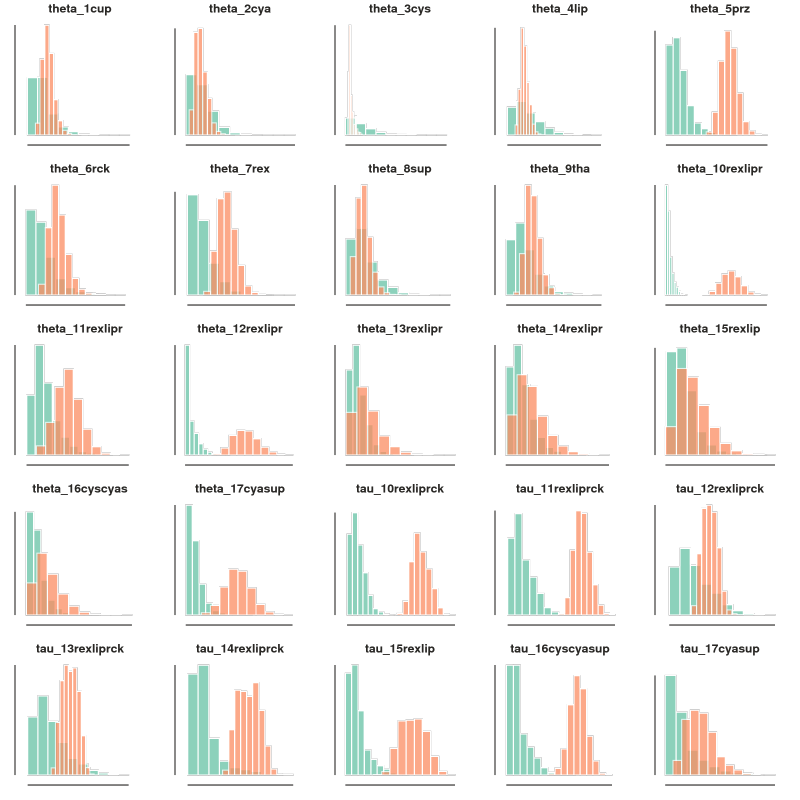

In [27]:
## draw barplots
canvas = toyplot.Canvas(width=800, height=800)

for aidx in range(table1.shape[1]):
    ## get data
    param = table1.columns[aidx]
    hist1 = np.histogram(table1[param], density=True)
    hist2 = np.histogram(table2[param], density=True)
    
    ## build plot
    nx = int(np.sqrt(table1.shape[1]))
    axes = canvas.cartesian(grid=(nx, nx, aidx), gutter=25)
    axes.bars(hist1, opacity=0.75)
    axes.bars(hist2, opacity=0.75)
    
    ## style axes
    axes.label.text = param[:15]
    axes.label.style["font-size"] = "12px"
    #axes.label.style["text-anchor"] = "end"
    #print axes.label.style
    axes.x.ticks.labels.show = False
    axes.y.ticks.labels.show = False
    
## save plot to pdf
import toyplot.pdf
toyplot.pdf.render(canvas, "analysis-bpp/bpp-A00.pdf")
canvas

----------------------------------------

## Algorithm 10 - species tree inference

The algorithm 10 aims to infer the correct species tree from the data by implemented a tree search method, thus the input tree is treated only as a starting tree. Based on the results above I'm also going to increase the priors on the divergence times (tau) by about 10X. 

In [291]:
## create new bpp objects
A10 = A00.copy("A10")
A10n = A00.copy("A10-nodata")

## set new params
A10.params.infer_sptree = 1
A10.params.infer_delimit = 0
A10.params.tauprior = (2, 200, 1)
A10n.params.infer_sptree = 1
A10n.params.infer_delimit = 0
A10n.params.tauprior = (2, 200, 1)

## also set no-data on the 'n' copy
A10n.params.usedata = 0

In [292]:
## submit job reps to the cluster
A10.run(nreps=2, randomize_order=True, ipyclient=ipyclient)
A10n.run(nreps=1, randomize_order=True, ipyclient=ipyclient)

submitted 2 bpp jobs [A10] (100 loci)
submitted 1 bpp jobs [A10-nodata] (100 loci)


In [293]:
## block until finished
ipyclient.wait()

True

#### Plot the distribution of species trees from algorithm 10
Here we use the `multitree()` object of toytree to plot the posterior distribution of trees. The code for drawing 'cloudtrees' here is still in development and a littl clunky, but will improve in the future. From the example here (which has not been run long enough, btw), you can see clearly that the two replicates yield quite different trees. In this case the replicates are starting from different random seeds, but probably more importantly they are sampling a different random subset of 100 RAD loci that met our filtering requirements (e.g., minsamples, minSNPs). 

In [295]:
## load trees slicing out every Nth: (start:end:by)
trees1 = toytree.multitree(
    newick=A10.files.mcmcfiles[0],
    treeslice=(350, 5000, 5),
    )

## build canvas
canvas = toyplot.Canvas(width=800, height=400)
axes1 = canvas.cartesian(grid=(1, 2, 0), padding=25)
axes2 = canvas.cartesian(grid=(1, 2, 1), padding=25)

## draw cloud tree
trees1.draw_cloudtree(
    axes=axes1,
    use_edge_lengths=True,
    orient='right',
    edge_style={"opacity": 0.025},
);

## draw consensus (doesn't save edge lengths currently)
cons = trees1.get_consensus_tree()
cons.root(wildcard="prz")
cons.draw(
    axes=axes2,
    node_labels=cons.get_node_values("support"),
);

## style axes
axes1.y.show = False
axes2.y.show = False

<g class="toyplot-Datum" style="fill:rgb(65.1%,84.7%,32.9%);fill-opacity:1.0;opacity:1.0;stroke:rgb(65.1%,84.7%,32.9%);stroke-opacity

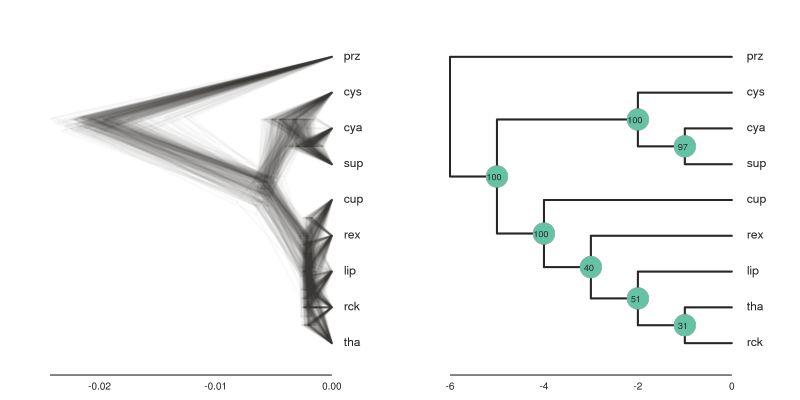

In [296]:
## load trees slicing out every 100th: [100:10000:100]
trees2 = toytree.multitree(
    newick=A10.files.mcmcfiles[1],
    treeslice=(350, 5000, 5),
    )

## build canvas
canvas = toyplot.Canvas(width=800, height=400)
axes1 = canvas.cartesian(grid=(1, 2, 0), padding=25)
axes2 = canvas.cartesian(grid=(1, 2, 1), padding=25)

## draw cloud tree
trees2.draw_cloudtree(
    axes=axes1,
    use_edge_lengths=True,
    orient='right',
    edge_style={"opacity": 0.025},
);

## draw consensus (doesn't save edge lengths currently)
cons = trees2.get_consensus_tree()
cons.root(wildcard="prz")
cons.draw(
    axes=axes2,
    node_labels=cons.get_node_values("support"),
);

## style axes and save
axes1.y.show = False
axes2.y.show = False
toyplot.html.render(canvas, "analysis-bpp/tree.html")
canvas

-------------------------

### Running other algorithms
The species delimitation algorithms (01 and 11) are a bit more difficult to summarize the results of, so we do not have a recommended way yet other than to look at the .out.txt file produced by the run. Have fun. 

### Setting up tests of multiple prior settings
Rannala and Yang suggest that you try out several species delimitation algorithms and that you do so over a range of params for the two algorithms. They suggest that you run algorithm 0 with $\epsilon$=(2, 5, 10, 20), and algorithm 1 with $\alpha$=(1, 1.5, 2) and $m$=(1, 1.5, 2). And also to do this with different starting trees. Using our programmatic approach you can easily set up all of these tests and run them in parallel using a simple for-loop setup.  

In [297]:
## create a bpp object with algorithm 01 settings
A01 = A10.copy(name="A01")
A01.params.infer_sptree = 0
A01.params.infer_delimit = 1

In [298]:
## submit jobs using a range of param options
DELIMIT_TESTS = [
    (0, 2),
    (0, 5),
    (0, 10),
    (1, 1.0, 1.0),
    (1, 1.0, 1.5),
    (1, 1.0, 2.0),
    (1, 1.5, 1.0), 
    (1, 1.5, 1.5), 
    (1, 1.5, 2.0),
    (1, 2.0, 1.0), 
    (1, 2.0, 1.5), 
    (1, 2.0, 2.0)
]

## a dictionary to store our bpp objects
bpps = {}

## iterate over delimit args
for test in DELIMIT_TESTS:
    ## make a copy
    name = "A10-{}".format("-".join([str(i) for i in test]))
    bpps[name] = A10.copy(name)
    
    ## set the delimit algorithm
    bpps[name].params.delimit_alg = test
    
    ## submit the job
    bpps[name].run(nreps=1, seed=123, ipyclient=ipyclient)

submitted 1 bpp jobs [A10-0-2] (100 loci)
submitted 1 bpp jobs [A10-0-5] (100 loci)
submitted 1 bpp jobs [A10-0-10] (100 loci)
submitted 1 bpp jobs [A10-1-1.0-1.0] (100 loci)
submitted 1 bpp jobs [A10-1-1.0-1.5] (100 loci)
submitted 1 bpp jobs [A10-1-1.0-2.0] (100 loci)
submitted 1 bpp jobs [A10-1-1.5-1.0] (100 loci)
submitted 1 bpp jobs [A10-1-1.5-1.5] (100 loci)
submitted 1 bpp jobs [A10-1-1.5-2.0] (100 loci)
submitted 1 bpp jobs [A10-1-2.0-1.0] (100 loci)
submitted 1 bpp jobs [A10-1-2.0-1.5] (100 loci)
submitted 1 bpp jobs [A10-1-2.0-2.0] (100 loci)
